## Note

Run `test_minEffectiveSize.R` and `test_similarity.R` in `Validation` folder before the notebook.

In [1]:
library(ape)
library(sitePath)
library(ggplot2)

VALIDATION_DIR <- "Validation"
PLOTS_DIR <- "Plots"

In [2]:
tree <- read.tree(file.path("Trees", "H1N1_HA", "RAxML_bestTree.PROTGAMMAGTR"))
tree <- drop.tip(tree, "MK615591")
tree <- addMSA(tree, msaPath = file.path("Trees", "H1N1_HA", "aligned.fasta"), msaFormat = "fasta")
nTip <- Ntip(tree)

In [3]:
paths <- lineagePath(tree, similarity = 0.01)

In [4]:
mutations <- fixationSites(lineagePath(tree))
align <- attr(attr(mutations, "paths"), "align")

In [5]:
fixationSites <- readLines(file.path(VALIDATION_DIR, "sites.txt"))
fixationSites <- as.integer(fixationSites)

loci <- which(vapply(
    X = seq_along(attr(mutations, "reference")),
    FUN = function(s) {
        length(unique(substr(align, s, s))) > 1
    },
    FUN.VALUE = logical(1)
))

siteCategory <- data.frame(
    "site" = integer(),
    "category" = character(),
    "fixationSite" = logical()
)
siteCategory <- rbind(
    siteCategory,
    data.frame(
        "site" = fixationSites,
        "category" = rep("fixed", length(fixationSites)),
        "fixationSite" = rep(TRUE, length(fixationSites))
    )
)

conservedSites <- setdiff(loci, fixationSites)
siteCategory <- rbind(
    siteCategory,
    data.frame(
        "site" = conservedSites,
        "category" = rep("conserved", length(conservedSites)),
        "fixationSite" = rep(FALSE, length(conservedSites))
    )
)
siteCategory <- siteCategory[order(siteCategory[["site"]]), ]
row.names(siteCategory) <- NULL

nPositive <- sum(siteCategory[["fixationSite"]] == TRUE)
nNegative <- sum(siteCategory[["fixationSite"]] == FALSE)

### 1. similarity

Test the `similarity` parameter in `fixationSites` function.

In [13]:
testParam <- "similarity"
res <- readRDS(file.path(VALIDATION_DIR, paste0(testParam, ".rds")))

In [14]:
predResult <- data.frame(
    "similarity" = double(),
    "minEffectiveSize" = integer(),
    "rate" = double(),
    "category" = character()
)

for (similarity in names(res)) {
    for (minEffectiveSize in names(res[[similarity]])) {
        mutations <- res[[similarity]][[minEffectiveSize]]
        assessTable <- siteCategory
        sites <- as.integer(names(mutations))
        assessTable[["predFixed"]] <- assessTable[["site"]] %in% sites
        x <- assessTable[["fixationSite"]] + assessTable[["predFixed"]]
        senstivity <- length(which(x == 2)) / nPositive
        specificity <- length(which(x == 0)) / nNegative
        
#         percentage <- as.integer(minEffectiveSize) / nTip
        predResult <- rbind(
            predResult,
            data.frame(
                "similarity" = as.double(c(similarity, similarity)),
                "minEffectiveSize" = as.integer(c(minEffectiveSize, minEffectiveSize)),
                "rate" = c(senstivity, specificity),
                "category" = c("Senstivity", "Specificity")
            )
        )
    }
}

predResult <- predResult[which(predResult$minEffectiveSize == 30), ]

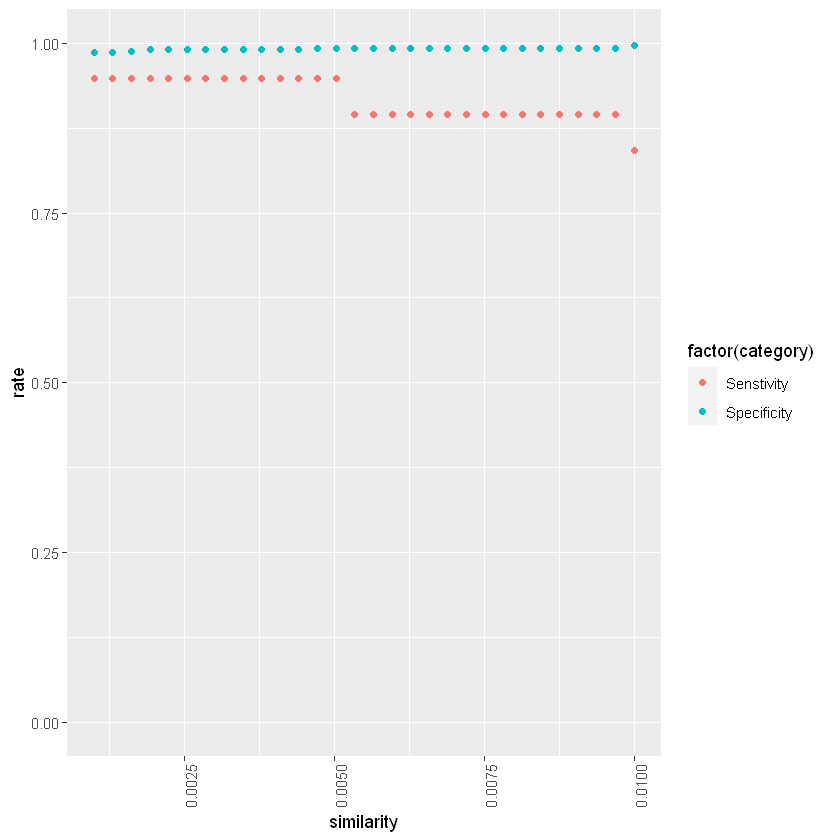

In [15]:
p <- ggplot(predResult, aes(similarity, rate)) +
    geom_point(aes(color = factor(category))) + ylim(0, 1) + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1))
p

ggsave(
    filename = file.path(PLOTS_DIR, paste0(testParam, ".pdf")),
    plot = p,
    device = "pdf",
    width = 3.25, height = 2
)

### 2. minEffectiveSize

Test the `minEffectiveSize` parameter in `fixationSites` function.

In [9]:
testParam <- "minEffectiveSize"

res <- readRDS(file.path(VALIDATION_DIR, paste0(testParam, ".rds")))

In [10]:
predResult <- data.frame(
    "similarity" = double(),
    "minEffectiveSize" = integer(),
    "rate" = double(),
    "category" = character()
)

for (similarity in names(res)) {
    for (minEffectiveSize in names(res[[similarity]])) {
        mutations <- res[[similarity]][[minEffectiveSize]]
        assessTable <- siteCategory
        sites <- as.integer(names(mutations))
        assessTable[["predFixed"]] <- assessTable[["site"]] %in% sites
        x <- assessTable[["fixationSite"]] + assessTable[["predFixed"]]
        senstivity <- length(which(x == 2)) / nPositive
        specificity <- length(which(x == 0)) / nNegative
        
        percentage <- as.integer(minEffectiveSize) / nTip
        predResult <- rbind(
            predResult,
            data.frame(
                "similarity" = as.double(c(similarity, similarity)),
                "minEffectiveSize" = c(percentage, percentage),
                "rate" = c(senstivity, specificity),
                "category" = c("Senstivity", "Specificity")
            )
        )
    }
}
predResult <- predResult[which(predResult$similarity == 0.001), ]

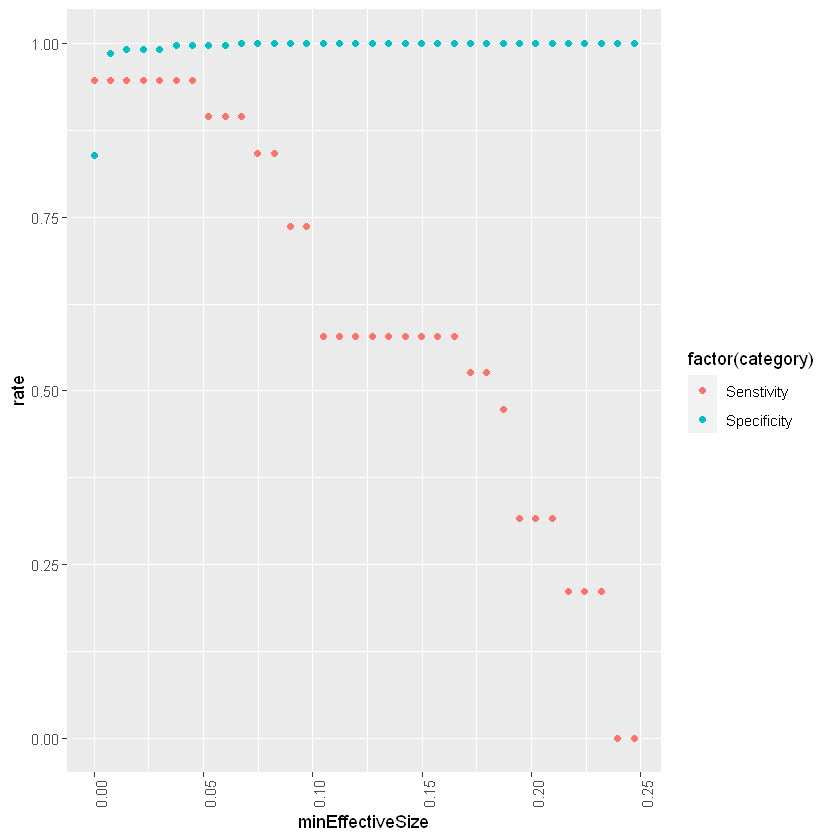

In [12]:
p <- ggplot(predResult, aes(minEffectiveSize, rate)) +
    geom_point(aes(color = factor(category))) + ylim(0, 1) + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1))
p

ggsave(
    filename = file.path(PLOTS_DIR, paste0(testParam, ".pdf")),
    plot = p,
    device = "pdf",
    width = 3.25, height = 2
)